# Clean Version of Model 01

In [6]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import datetime
from datetime import datetime as dt
import gc

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

# Needed functions

In [2]:
# get missing data
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

# fix missing weather data
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

# reduce memory
def reduce_mem_usage(df, use_float16=False):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Load Training Data

In [4]:
PATH = PATH = './data/'

train_df = pd.read_csv(PATH + 'train.csv')

building_df = pd.read_csv(PATH + 'building_metadata.csv')

weather_df = pd.read_csv(PATH + 'weather_train.csv')

In [7]:
# fix weather data
weather_df = fill_weather_dataset(weather_df)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [19]:
# Outlier removal
# According to discussions on kaggle: 
    # https://www.kaggle.com/c/ashrae-energy-prediction/discussion/120694#latest-690700
    # https://www.kaggle.com/c/ashrae-energy-prediction/discussion/114830#latest-680086

train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Reduce Memory

In [21]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.4%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.66 MB
Decreased by 72.5%


# Join Data

In [22]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

In [23]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,105,0,2016-01-01 00:00:00,23.303600,1,Education,50623,NaN,5.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609
1,106,0,2016-01-01 00:00:00,0.374600,1,Education,5374,NaN,4.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609
2,106,3,2016-01-01 00:00:00,0.000000,1,Education,5374,NaN,4.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609
3,107,0,2016-01-01 00:00:00,175.184006,1,Education,97532,2005.0,10.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609
4,108,0,2016-01-01 00:00:00,91.265297,1,Education,81580,1913.0,5.0,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609


In [24]:
# missing points
missing_statistics(train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,19852422,0.00
1,meter,0,19852422,0.00
2,timestamp,0,19852422,0.00
3,meter_reading,0,19852422,0.00
4,site_id,0,19852422,0.00
5,primary_use,0,19852422,0.00
6,square_feet,0,19852422,0.00
7,year_built,12110079,19852422,61.00
8,floor_count,16345489,19852422,82.33
9,air_temperature,0,19852422,0.00


In [26]:
# holiday calendar import --> some kernels say that all buildings are located in the US
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# feature function
def select_features(df_given, drop_cols, build_lags_for, window=3):
    # copy data
    df = df_given.copy()
    # Sort by timestamp
    df.sort_values("timestamp")
    # reset index
    df.reset_index(drop=True)
    
    # seperate the timestamp into individual features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # build in holiday feature
    min_date = pd.to_datetime(df["timestamp"].iloc[0],format="%Y-%m-%d")
    max_date = pd.to_datetime(df["timestamp"].iloc[-1],format="%Y-%m-%d")
    
    date_range = pd.date_range(start=min_date, end=max_date)
    us_holidays = calendar().holidays(start=date_range.min(), end=date_range.max())
    
    df['is_holiday'] = (df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    
    # build weekend classification (weekday starts at 0)
    df['is_weekend'] = np.where( (df["weekday"] == 5) | (df["weekday"] == 6), 1, 0 )
    
    # build lags
    if build_lags_for:
        rolled = df[build_lags_for].rolling(window=window, min_periods=0)
        lag_mean = rolled.mean().reset_index().astype(np.float16)
        lag_std = rolled.std().reset_index().astype(np.float16)
        
        for col in build_lags_for:
            df[f'{col}_mean_lag{window}'] = lag_mean[col]
        
    df = df.drop(drop_cols, axis=1)
    
    # transform the primary usage to a number
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    gc.collect()
    return df

In [29]:
# model build
def build_model(t, f, categorical, params, splits):
    # measure time
    total_start = dt.now()
    
    # t = target
    # f = features
    # categorical = categorical features of the dataset
    # params = model parameters --> used to change to find best fit
    # splits = kfolf number of splits
    
    kf = KFold(n_splits=splits)
    # collect models
    models = []
    
    for train_index,test_index in kf.split(f):
        model_start = dt.now()
        # train
        train_features = f.loc[train_index]
        train_target = t.loc[train_index]
        
        # test
        test_features = f.loc[test_index]
        test_target = t.loc[test_index]
        
        d_train = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical, free_raw_data=False)
        d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical, free_raw_data=False)
        # explanation:
        '''
            label: (list, numpy 1-D array, pandas Series / one-column DataFrame or None, optional (default=None)) – Label of the data.
            loading numpy array in the datasettt
            free_raw_data: saves memory if set to true --> i´m not concerned on my pc
            details:
            https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html
        '''
        model = lgb.train(
             params, 
             train_set=d_train, 
             num_boost_round=1000, 
             valid_sets=[d_train,d_test], 
             verbose_eval=25, 
             early_stopping_rounds=50
        )
        # append model to list
        models.append(model)
        del train_features, train_target, test_features, test_target, d_train, d_test
        gc.collect()
        
        model_end = dt.now()
        print('KFold time:', model_end - model_start)
        
    total_end = dt.now()
    print('Total time:', total_end - total_start)
    
    return models

In [27]:
# build features
train_df_features = select_features(
    train_df,
    ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"],
    ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr'],
    window=72
)

# Build the model
### target and features

In [30]:
# Test 1:
target = np.log1p(train_df_features["meter_reading"])
features = train_df_features.drop('meter_reading', axis = 1)

categorical_features = [
    "building_id", "site_id", 'primary_use', 
    'hour', 'weekday', 'meter',
    'is_holiday', 'is_weekend'
]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

test_1 = build_model(target, features, categorical_features, params, 3)

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.48411	valid_1's rmse: 1.62051
[50]	training's rmse: 1.28395	valid_1's rmse: 1.4585
[75]	training's rmse: 1.14494	valid_1's rmse: 1.32712
[100]	training's rmse: 1.04808	valid_1's rmse: 1.27375
[125]	training's rmse: 1.01089	valid_1's rmse: 1.25089
[150]	training's rmse: 0.974298	valid_1's rmse: 1.21898
[175]	training's rmse: 0.940883	valid_1's rmse: 1.20215
[200]	training's rmse: 0.918316	valid_1's rmse: 1.18291
[225]	training's rmse: 0.897758	valid_1's rmse: 1.17228
[250]	training's rmse: 0.88128	valid_1's rmse: 1.16849
[275]	training's rmse: 0.870748	valid_1's rmse: 1.16423
[300]	training's rmse: 0.861275	valid_1's rmse: 1.15946
[325]	training's rmse: 0.853442	valid_1's rmse: 1.15489
[350]	training's rmse: 0.84508	valid_1's rmse: 1.14881
[375]	training's rmse: 0.838394	valid_1's rmse: 1.14545
[400]	training's rmse: 0.833539	valid_1's rmse: 1.14296
[425]	training's rmse: 0.829295	valid_1's rmse: 1.1412

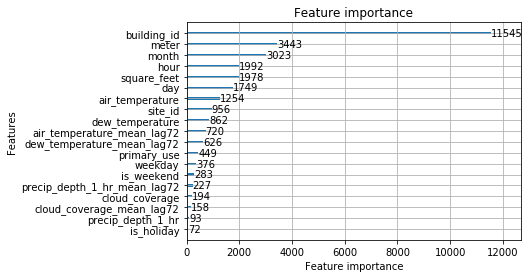

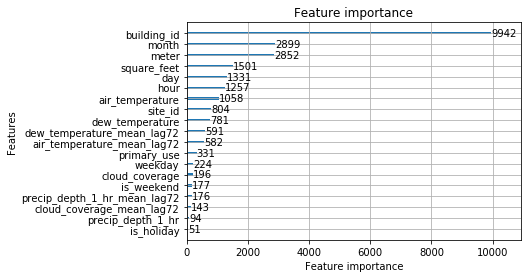

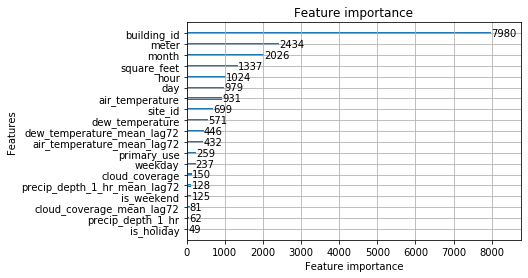

In [48]:
# show importance
for model in test_1:
    lgb.plot_importance(model)
    plt.show()

In [56]:
# according to the relevance, let´s try a model with only top features
# drop: 'is_holiday', 'precip_depth_1_hr', 'is_weekend', 'cloud_coverage', 'primary_use', 'weekday'

# build features
train_df_features_important = select_features(
    train_df,
    ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count",
     'is_holiday', 'precip_depth_1_hr', 'is_weekend', 'cloud_coverage', 'weekday'],
    False
)

In [59]:
train_df_features_important = train_df_features_important.drop( ['primary_use'], axis=1 )
train_df_features_important.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,dew_temperature,hour,day,month
0,105,0,23.303600,1,10.832181,3.800781,2.400391,0,1,1
1,106,0,0.374600,1,8.589514,3.800781,2.400391,0,1,1
2,106,3,0.000000,1,8.589514,3.800781,2.400391,0,1,1
3,107,0,175.184006,1,11.487946,3.800781,2.400391,0,1,1
4,108,0,91.265297,1,11.309352,3.800781,2.400391,0,1,1


In [70]:
# Test 2:
target = np.log1p(train_df_features_important["meter_reading"])
features = train_df_features_important.drop('meter_reading', axis = 1)

categorical_features = [
    "building_id", "site_id", 
    'hour', 'day', 'month', 'meter',
]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 70,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

test_2 = build_model(target, features, categorical_features, params, 3)

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.37796	valid_1's rmse: 1.53257
[50]	training's rmse: 1.11874	valid_1's rmse: 1.31935
[75]	training's rmse: 0.998052	valid_1's rmse: 1.22885
[100]	training's rmse: 0.925094	valid_1's rmse: 1.19118
[125]	training's rmse: 0.879861	valid_1's rmse: 1.16802
[150]	training's rmse: 0.852048	valid_1's rmse: 1.1505
[175]	training's rmse: 0.827893	valid_1's rmse: 1.13651
[200]	training's rmse: 0.812431	valid_1's rmse: 1.12956
[225]	training's rmse: 0.801701	valid_1's rmse: 1.12267
[250]	training's rmse: 0.790471	valid_1's rmse: 1.11686
[275]	training's rmse: 0.782866	valid_1's rmse: 1.11215
[300]	training's rmse: 0.777882	valid_1's rmse: 1.1092
[325]	training's rmse: 0.769199	valid_1's rmse: 1.1061
[350]	training's rmse: 0.762952	valid_1's rmse: 1.10305
[375]	training's rmse: 0.756241	valid_1's rmse: 1.1006
[400]	training's rmse: 0.752684	valid_1's rmse: 1.0991
[425]	training's rmse: 0.748139	valid_1's rmse: 1.097

## ok, we see some improvement across the folds
### seems like a little overfitting with too much params
# Load test data

In [62]:
test_df = pd.read_csv(PATH + 'test.csv')

row_ids = test_df["row_id"]

test_df.drop("row_id", axis=1, inplace=True)

test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


In [63]:
# merge data
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')

In [64]:
test_df.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN
1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN
2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN
3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN
4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN


In [65]:
# get test weather and fill it
weather_df = pd.read_csv(PATH + 'weather_test.csv')

weather_df = fill_weather_dataset(weather_df)

weather_df = reduce_mem_usage(weather_df)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 9.05 MB
Decreased by 53.0%


In [66]:
# merge with weather data
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])

test_df.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.799999,4.0,11.7,0.282609,1021.400024,100.0,3.6
1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.799999,4.0,11.7,0.282609,1021.400024,100.0,3.6
2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.799999,4.0,11.7,0.282609,1021.400024,100.0,3.6
3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.799999,4.0,11.7,0.282609,1021.400024,100.0,3.6
4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.799999,4.0,11.7,0.282609,1021.400024,100.0,3.6


In [67]:
# build features
test_df_features = select_features(
    test_df,
    ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count",
     'is_holiday', 'precip_depth_1_hr', 'is_weekend', 'cloud_coverage', 'weekday'],
    False
)

In [68]:
test_df_features = test_df_features.drop( ['primary_use'], axis=1 )
test_df_features.head()

,building_id,meter,site_id,square_feet,air_temperature,dew_temperature,hour,day,month
0,0,0,0,8.913685,17.799999,11.7,0,1,1
1,1,0,0,7.908755,17.799999,11.7,0,1,1
2,2,0,0,8.589886,17.799999,11.7,0,1,1
3,3,0,0,10.072639,17.799999,11.7,0,1,1
4,4,0,0,11.666573,17.799999,11.7,0,1,1


# Prediction

In [71]:
prediction_start = dt.now()

results = []
for model in test_2:
    if  results == []:
        results = np.expm1(model.predict(test_df_features, num_iteration=model.best_iteration)) / len(test_2)
    else:
        results += np.expm1(model.predict(test_df_features, num_iteration=model.best_iteration)) / len(test_2)
    del model
    gc.collect()
    
print('Prediction Time:', dt.now() - prediction_start)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


Prediction Time: 0:12:40.046537


In [72]:
# Submission
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
results_df.to_csv("submission_01_new.csv", index=False)

In [73]:
results_df.head(20)

,row_id,meter_reading
0,0,182.119210
1,1,82.504150
2,2,13.559072
3,3,271.598035
4,4,1156.066029
5,5,27.670650
6,6,94.189268
7,7,381.967586
8,8,345.152747
9,9,329.553354
